<a href="https://colab.research.google.com/github/ishika-mittal/Stock-Prices-Analytics-Dashboard/blob/main/Money_Flow_Index_(MFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Money Flow Index**

1. MFI generates overbought or oversold signals using both prices and volume data.

2. An MFI reading > 80 is considered overbought and an MFI reading < 20 is considered oversold.

3. MFI is most beneficial when there is a divergence. A divergence is when the oscillator is moving in the opposite direction of price. This is a signal of a potential reversal in the prevailing price trend.

4. Ex- a very high MFI, which begins to fall below 80, even when the closing price is increasing is a price reversal signal to the downside and vice-versa.

5. In an uptrend, a drop < 20-30 followed by a rally back above it could indicate a pullback is over and the price uptrend is resuming. The same goes for a downtrend. A short-term rally could push the MFI up to 70 or 80, but when it drops back below that could be the time to enter a short trade in preparation for another drop.

Details: https://www.investopedia.com/terms/m/mfi.asp 

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Installing yfinance library for fetching historical stock data
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3MB 21.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=e90529ad75509323d1e910d3c355ae8401047e5fedb820ee088b45d6be800a78
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
#Function to get the stock data
def stock_data(stock, start_date, end_date):

    tickerSymbol = stock

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

    return tickerDf

In [4]:
#Fetching a 1Y dataset for better representation

df = stock_data("ITC.BO", "2020-06-08", "2021-06-08")
df.reset_index(level="Date", inplace=True)
df.drop(columns = ['Dividends', 'Stock Splits'], inplace=True)

print(df.shape)
df.head()

(250, 6)


,Date,Open,High,Low,Close,Volume
0,2020-06-08,182.945035,184.074883,178.199672,178.742004,744734
1,2020-06-09,179.826649,186.289389,178.696801,179.510300,1341970
2,2020-06-10,180.052627,183.668142,179.284339,180.097824,1024793
3,2020-06-11,180.775730,181.905578,174.990912,175.894791,855456
4,2020-06-12,171.375387,176.482296,169.974373,175.352448,980250


In [5]:
#Creating a dataset with only Closing Price column and Date as index

data = df.sort_index(ascending=True,axis=0)
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df1["Date"][i]=data['Date'][i]
    df1["Close"][i]=data["Close"][i]

df1.index=df1.Date
df1.drop("Date",axis=1,inplace=True)
print(df1.shape)
df1.head()

(250, 1)


,Close
Date,
2020-06-08,178.742
2020-06-09,179.51
2020-06-10,180.098
2020-06-11,175.895
2020-06-12,175.352


In [6]:
#Defining Function

def MFI(data, period):

  #Calculating the typical price
  typical_price = (data['Close'] + data['High'] + data['Low']) / 3

  #Calculate the money flow
  money_flow = typical_price * data['Volume']

  #Get all of the positive and negative money flows 
  positive_flow =[]
  negative_flow = []

  for i in range(1, len(typical_price)):
    if typical_price[i] > typical_price[i-1]: #if the present typical price is greater than yesterdays typical price
      positive_flow.append(money_flow[i-1])# Then append money flow at position i-1 to the positive flow list
      negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]:#if the present typical price is less than yesterdays typical price
      negative_flow.append(money_flow[i-1])# Then append money flow at position i-1 to negative flow list
      positive_flow.append(0)
    else:
      positive_flow.append(0)
      negative_flow.append(0)
  
  #Get all of the positive and negative money flows within the time period
  positive_mf =[]
  negative_mf = [] 

  for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i+1-period : i+1]))
  for i in range(period-1, len(negative_flow)):
    negative_mf.append(sum(negative_flow[i+1-period : i+1]))

  #Calculating MFI
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf) ))

  #Creating a new DataFrame as MFI and df was different indices by delta

  new_df = pd.DataFrame()
  new_df = data[period:]
  new_df['MFI'] = MFI

  return MFI, new_df

In [7]:
#Implementing Function

Money_Flow_Index, new_df = MFI(df,14)
new_df.head()

,Date,Open,High,Low,Close,Volume,MFI
14,2020-06-26,185.747074,189.136619,174.719756,176.346741,5776272,63.041321
15,2020-06-29,183.577750,183.577750,177.386176,178.244858,2641793,47.483800
16,2020-06-30,181.679608,181.679608,175.352458,175.894791,1763570,45.179282
17,2020-07-01,176.256339,184.210474,176.120763,183.216202,1762903,50.402343
18,2020-07-02,184.662399,186.876899,183.170991,186.198990,1427773,55.046204


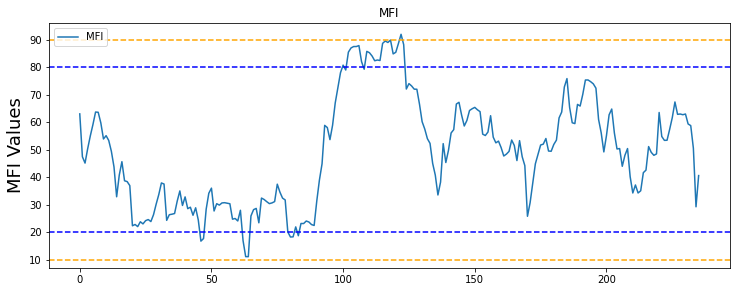

In [8]:
#Plotting The Money Flow Index
df2 = pd.DataFrame()
df2['MFI'] = Money_Flow_Index

plt.figure(figsize=(12.2,4.5))
plt.plot( df2['MFI'],  label='MFI')

plt.axhline(10, linestyle='--', color = 'orange')  #Over Sold line (Buy)
plt.axhline(20, linestyle='--',color = 'blue')  #Over Sold Line (Buy)
plt.axhline(80, linestyle='--', color = 'blue')  #Over Bought line (Sell)
plt.axhline(90, linestyle='--', color = 'orange')  #Over Bought line (Sell)

plt.title('MFI')
plt.ylabel('MFI Values',fontsize=18)
plt.legend(df2.columns.values, loc='upper left')

plt.show()